In [1]:
from doc2text.reader import Reader
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import pytesseract
import os
import warnings
import keras_ocr
import tensorflow
from tqdm import tqdm

warnings.simplefilter('ignore')

In [ ]:
class GetBoxes:
    def __init__(self) -> None:
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        self.pipeline = keras_ocr.pipeline.Pipeline()
        self.reader = Reader()
    
    @staticmethod
    def resize_box(box, c=10):
        box[0][0] -= c
        box[0][1] -= c
        box[1][0] += c
        box[1][1] -= c
        box[2][0] += c
        box[2][1] += c
        box[3][0] -= c
        box[3][1] += c
        return box


    @staticmethod
    def crop_rectangle(image: np.ndarray, box: np.ndarray) -> np.ndarray:
        """
        Вырезает прямоугольник из изображения по координатам четырех углов.

        Параметры:
        image (np.ndarray): Изображение, из которого нужно вырезать прямоугольник.
        box (np.ndarray): Массив координат четырех углов прямоугольника.

        Возвращает:
        np.ndarray: Вырезанный прямоугольник.
        """
        # Находим размер вырезаемого прямоугольника
        width = int(np.linalg.norm(box[0] - box[1]))
        height = int(np.linalg.norm(box[1] - box[2]))

        # Определяем целевые точки (прямоугольник с найденными размерами)
        dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

        # Вычисляем матрицу перспективного преобразования
        M = cv2.getPerspectiveTransform(box.astype("float32"), dst_pts)

        # Применяем преобразование и вырезаем прямоугольник
        cropped_image = cv2.warpPerspective(image, M, (width, height))

        return cropped_image


    def get_box(self, img_path: str, img_to='temp') -> list:
        if not os.path.exists(img_to):
            os.mkdir(img_to)
        image = keras_ocr.tools.read(img_path)
        predictions = self.pipeline.recognize([image])[0]
        boxes = [self.resize_box(box) for _, box in predictions]
        final = []
        for i, box in tqdm(enumerate(boxes)):
            src = img_to + os.sep + f'{i}.jpg'
            img = self.crop_rectangle(image, box)
            img = Image.fromarray(img)
            img.save(src)
            line_ruk = self.reader.doc2text(src)
            line_doc = pytesseract.image_to_string(img, lang='rus')
            final.append([line_ruk[0], line_doc])
            #os.remove(src)
        return final

In [ ]:
gtb = GetBoxes()

Looking for C:\Users\User\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\User\.keras-ocr\crnn_kurapan.h5
recognizer weights has loaded from c:\Users\User\Desktop\II\Tekst\train_RZHD_TrudovieKnizhki\doc2text\weights/ocr_transformer_4h2l_simple_conv_64x256.pt


In [ ]:
answer = gtb.get_box(r'38\trudovaja_knizhka_1945_1986.jpg')

In [211]:
img = cv2.imread(r'38\trudovaja_knizhka_1945_1986.jpg')

In [ ]:
for i in sorted(os.listdir('temp'), key=lambda x: int(x.split('.')[0])):
    img = Image.open(os.sep.join(['temp', i]))
    img = ImageEnhance.Contrast(img)
    img_contrasted = img.enhance(1)
    img_contrasted.show()
    print(pytesseract.image_to_string(img_contrasted, lang='rus'))


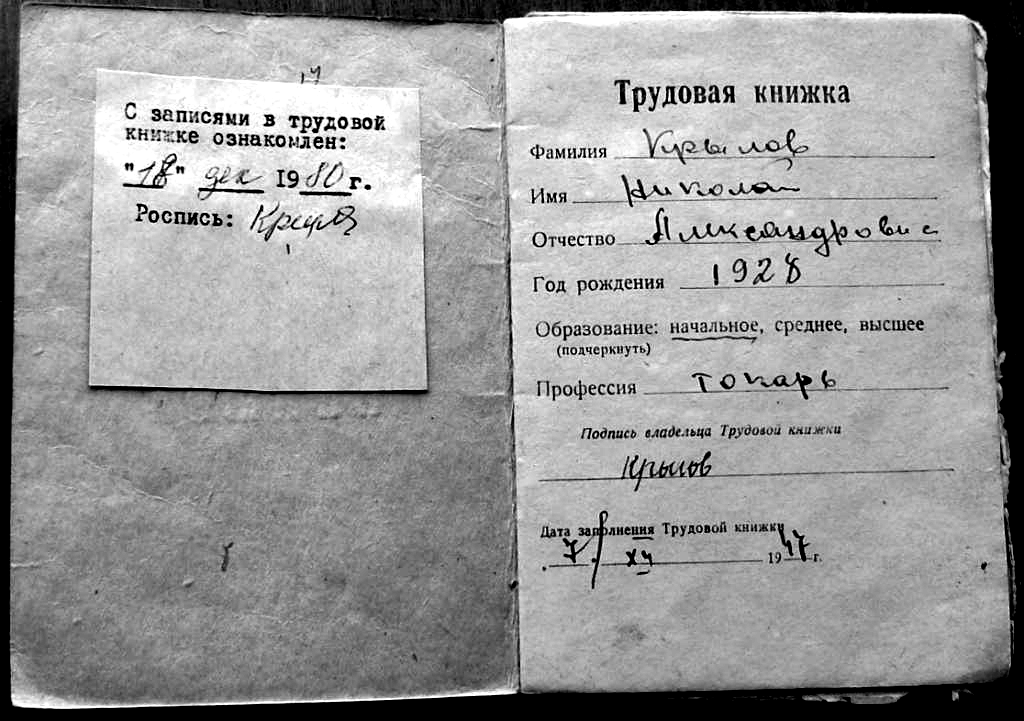

In [213]:
img = cv2.imread(r'38\trudovaja_knizhka_1945_1986.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = Image.fromarray(img)
img_contr = ImageEnhance.Contrast(img)
img_contrasted = img_contr.enhance(3)
img_contrasted

In [215]:
print(pytesseract.image_to_string(img_contrasted, lang='rus'))

Трудовая книжка
ПИСЯМИ
-ке ознаконщане о

"7# #- 190г
Роспись: //оство
'

Фамилия _ Сн люфо —
имя — \№ Укю ое —

о еасЬ ‘Алм оаа одо о б е
Год рождения. _‚‘ 912 Ъ с

Образование: начальное, среднее, высшее
ЕДЕНЕ
(подчерквуть)

Профессия _ © уе 6

Подпись еладельца_Трудовой книзжки

— аао —

— 7 Х— вебы

Дала иішш Трудовой книжк




In [258]:
from doc2text.reader import Reader
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

rd = Reader()

recognizer weights has loaded from c:\Users\User\Desktop\II\Tekst\train_RZHD_TrudovieKnizhki\doc2text\weights/ocr_transformer_4h2l_simple_conv_64x256.pt


In [259]:
def get_texts(img_path, se=15):
    img = cv2.imread(img_path)
    c = len(img) // se
    pt = 10
    tekst_ruk = []
    tekst_peh = []
    for i in range(len(img) // c):
        if i > 0 and i < len(img) // c:
            st = i * c - pt
            en = (i + 1) * c + pt
        else:
            st = i * c
            en = (i + 1) * c
        part = img[st: en]
        #Image.fromarray(part).show()
        tru = pytesseract.image_to_string(part, lang='rus')
        tekst_peh.append(tru)
        src = r'temp/1.jpg'
        Image.fromarray(part).save(src)
        trk = rd.doc2text(src)[0] 
        tekst_ruk.append(trk)
    return tekst_ruk, tekst_peh

In [266]:
from pymystem3 import Mystem

def find_FIO(text):
    m = Mystem()
    second_name = first_name = middle_name = None
    analyse = m.analyze(text)
    for word in analyse:
        try:
            analysis = word['analysis'][0]
        except:
            continue
        if 'имя' in analysis['gr']:
            first_name = word['text'].capitalize()
        elif 'фам' in analysis['gr']:
            second_name = word['text'].capitalize()
        elif 'отч' in analysis['gr']:
            middle_name = word['text'].capitalize()

    return second_name, first_name, middle_name

In [350]:
import re

def extract_date(text):
    text_new = ''.join(list(filter(lambda x: x != 'г', list(text))))
    date_pattern = re.compile(r'\b(?:\d{1,4}[-/.]\d{1,2}[-/.]\d{2,4}|\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4})\b')
    dates = re.findall(date_pattern, text_new)
    return dates


def is_month(txt):
    mnths = ['январ', 'феврал', 'март', 'апрел', 'май', 'мая', 'июн', 'июл', 'август', 'сентябр', 'октябр', 'ноябр', 'декабр']
    for m in mnths:
        if m in txt:
            return m
    return False

def just_year(txt):
    pattern = r'\b\d{4}г'
    matches = re.findall(pattern, txt)
    return matches

def get_dates(txt):
    dates = []
    for x in txt:
        rt = is_month(x)
        dt = extract_date(x)
        je = just_year(x)
        if dt:
            dates.extend(dt)
        elif rt:
            i = 0
            sp = x.split()
            for p, o in enumerate(sp):
                if rt in o:
                    i = p
            dates.append(' '.join(sp[i - 1 if i - 1 >= 0 else i: i + 2]))
        elif je:
            dates.extend(je)
    return dates

In [351]:
def get_numer_series(img_path):
    series = ['AT-VIII', 'AT-VII', 'AT-VI', 'AT-IV', 'AT-V', 'AT-III', 'AT-II', 'AT-I', 'AT-IX', 'AT-X', 'TK-III', 'TK-II', 'TK-I', 'TK']
    img = cv2.imread(img_path)
    txt = pytesseract.image_to_string(Image.fromarray(img[:img.shape[0] // 5, img.shape[1] // 2:]))
    final_ser = None
    for ser in series:
        if ser in txt:
            final_ser = ser
    num = None
    if ''.join(list(filter(str.isdigit, list(txt)))):
        num = ''.join(list(filter(str.isdigit, list(txt))))
    return num, final_ser

In [374]:
def get_information(img_path, u=15):
    tekst_ruk, tekst_peh = get_texts(img_path, u)
    tekst_peh = list(map(str.strip, tekst_peh))
    tekst_ruk = list(map(str.strip, tekst_ruk))
    txt_ruk = ' '.join(tekst_ruk)
    txt_peh = ' '.join(tekst_peh)
    fio = find_FIO(txt_ruk)
    dates = get_dates(tekst_ruk)
    brn = None
    data = None
    if dates:
        brn = dates[0]
    if len(dates) > 1:
        data = dates[-1]
    num, ser = get_numer_series(img_path)
    dct = {'Фамилия': fio[0], 'Имя': fio[1], 'Отчество': fio[2], 'Дата рождения': brn, 'Дата заполнения': data, 'Серия': ser, 'Номер': num}
    return dct, all(dct.values())

In [375]:
def get_full_info(img_path):
    past_info = None
    c_lst = [15, 17, 14, 16, 18]
    for i in c_lst:
        info, flag = get_information(img_path, i)
        if flag:
            past_info = info.copy()
            break
        if past_info is None:
            past_info = info.copy()
            continue
        for x, y in past_info.items():
            if y is None and info[x]:
                past_info[x] = info[x]
    return past_info

In [1]:
class TitleInformation:
    def __init__(self):
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        self.reader = Reader()
    
    def get_texts(self, img_path, se=15):
        img = cv2.imread(img_path)
        c = len(img) // se
        pt = 10
        tekst_ruk = []
        tekst_peh = []
        for i in range(len(img) // c):
            if i > 0 and i < len(img) // c:
                st = i * c - pt
                en = (i + 1) * c + pt
            else:
                st = i * c
                en = (i + 1) * c
            part = img[st: en]
            tru = pytesseract.image_to_string(part, lang='rus')
            tekst_peh.append(tru)
            src = r'temp/1.jpg'
            Image.fromarray(part).save(src)
            trk = self.reader.doc2text(src)[0] 
            tekst_ruk.append(trk)
        return tekst_ruk, tekst_peh

    @staticmethod
    def find_FIO(text):
        m = Mystem()
        second_name = first_name = middle_name = None
        analyse = m.analyze(text)
        for word in analyse:
            try:
                analysis = word['analysis'][0]
            except:
                continue
            if 'имя' in analysis['gr']:
                first_name = word['text'].capitalize()
            elif 'фам' in analysis['gr']:
                second_name = word['text'].capitalize()
            elif 'отч' in analysis['gr']:
                middle_name = word['text'].capitalize()

        return second_name, first_name, middle_name
    
    @staticmethod
    def extract_date(text):
        text_new = ''.join(list(filter(lambda x: x != 'г', list(text))))
        date_pattern = re.compile(r'\b(?:\d{1,4}[-/.]\d{1,2}[-/.]\d{2,4}|\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4})\b')
        dates = re.findall(date_pattern, text_new)
        return dates

    @staticmethod
    def is_month(txt):
        mnths = ['январ', 'феврал', 'март', 'апрел', 'май', 'мая', 'июн', 'июл', 'август', 'сентябр', 'октябр', 'ноябр', 'декабр']
        for m in mnths:
            if m in txt:
                return m
        return False

    @staticmethod
    def just_year(txt):
        pattern = r'\b\d{4}г'
        matches = re.findall(pattern, txt)
        return matches


    def get_dates(self, txt):
        dates = []
        for x in txt:
            rt = self.is_month(x)
            dt = self.extract_date(x)
            je = self.just_year(x)
            if dt:
                dates.extend(dt)
            elif rt:
                i = 0
                sp = x.split()
                for p, o in enumerate(sp):
                    if rt in o:
                        i = p
                dates.append(' '.join(sp[i - 1 if i - 1 >= 0 else i: i + 2]))
            elif je:
                dates.extend(je)
        return dates
    
    @staticmethod
    def get_numer_series(img_path):
        series = ['AT-VIII', 'AT-VII', 'AT-VI', 'AT-IV', 'AT-V', 'AT-III', 'AT-II', 'AT-I', 'AT-IX', 'AT-X', 'TK-III', 'TK-II', 'TK-I', 'TK']
        img = cv2.imread(img_path)
        txt = pytesseract.image_to_string(Image.fromarray(img[:img.shape[0] // 5, img.shape[1] // 2:]))
        final_ser = None
        for ser in series:
            if ser in txt:
                final_ser = ser
        num = None
        if ''.join(list(filter(str.isdigit, list(txt)))):
            num = ''.join(list(filter(str.isdigit, list(txt))))
        return num, final_ser
    
    @staticmethod
    def get_graduate(txt):
        obrz = ['высшее', 'среднее', 'начальное']
        for x in txt.split():
            for ob in obrz:
                if ob in x:
                    return x
        return 'Не определено'


    def get_information(self, img_path, u=15):
        tekst_ruk, tekst_peh = self.get_texts(img_path, u)
        tekst_peh = list(map(str.strip, tekst_peh))
        tekst_ruk = list(map(str.strip, tekst_ruk))
        txt_ruk = ' '.join(tekst_ruk)
        txt_peh = ' '.join(tekst_peh)
        fio = self.find_FIO(txt_ruk)
        dates = self.get_dates(tekst_ruk)
        brn = None
        data = None
        if dates:
            brn = dates[0]
        if len(dates) > 1:
            data = dates[-1]
        num, ser = self.get_numer_series(img_path)
        grad = self.get_graduate(txt_ruk + txt_peh)
        dct = {'Фамилия': fio[0], 'Имя': fio[1], 'Отчество': fio[2], 'Дата рождения': brn, 'Дата заполнения': data, 'Серия': ser, 'Номер': num, 'Образование': grad}
        return dct, all(dct.values())
    
    def get_full_info(self, img_path):
        past_info = None
        c_lst = [15, 17, 14, 16, 18]
        for i in c_lst:
            info, flag = self.get_information(img_path, i)
            if flag:
                past_info = info.copy()
                break
            if past_info is None:
                past_info = info.copy()
                continue
            for x, y in past_info.items():
                if y is None and info[x]:
                    past_info[x] = info[x]
        return past_info

In [2]:
title = TitleInformation()
title.get_full_info(r'39\39.1.JPG')

NameError: name 'pytesseract' is not defined